### Libraries

# Simple LSTM model for predicting Google Stock Price

**Using 5 years (2012-2016) of Google Stock Price data (OPEN PRICE) as training set, predict upward/downward trend of Google Stock OPEN PRICE in Jan 2017**

## I. Pre processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing Training Set

In [2]:
dataset_train = pd.read_csv('../input/udemydlatozlstmdata/Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values # Using OPEN PRICE

### Feature Scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Creating a data structure where each observation is comprised of 60 timestamps (X) and 1 output (y)

In [4]:
### Each element in X_train will be an array length 60 with corresponding length 1 (one output) y_train
X_train = []
y_train = []

for i in range(60, 1258): ###1258 is the length of training_set_scaled###
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

In [5]:
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

We need this flexibility in the shape of the data so that we can use other variables to train the RNN (+ Keras documentations specifies the input shape for RNN which is **3D Tensor shape (batch size, timesteps, input_dim/number of predictor vars) Optional: 2D tensors with shape (batch_size, output_dim)**

In [6]:
# Shape of X_train before this step was (1198, 60) and now it's (1198, 60, 1) with 3 dimensions
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## II. Building and Training RNN

### Import Keras Libraries and packages

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [8]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [9]:
## Units = number of neurons (in the first layer) / return_sequences = True when we are going to add more layers later
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

## dropout regularization
### 0.2=20% of neurons of LSTM layer will be ignored during training during propagation (10 neurons will be ignored for each iteration of the training)
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [10]:
regressor.add(LSTM(units = 50, return_sequences = True))

## dropout regularization
### 0.2=20% of neurons of LSTM layer will be ignored during training during propagation (10 neurons will be ignored for each iteration of the training)
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [11]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [12]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [13]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [14]:
### For RNN, RMSprop is usually a good optimizer; but for this specific problem, adam works better, so chose adam
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [15]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0406
Epoch 2/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 3/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0060
Epoch 4/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 6/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0053
Epoch 7/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0046
Epoch 8/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0040
Epoch 10/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0042
Epoch 11/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0041
Epoch 12/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0040
Epoch 13/100
38/38 [=====

## III. Making the predictions and visualising the results

### Getting the real stock price of 2017

In [16]:
dataset_test = pd.read_csv('../input/udemydlatozlstmdata/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2017

In [17]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

In [18]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) ## apply max-min scaling normalization that has been already trained on training set

In [20]:
X_test = []
for i in range(60, 80): ### 80 is len(inputs) for prediction ###
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [21]:
predicted_stock_price = regressor.predict(X_test)

In [23]:
### Return the scaled prediction values to non-scale values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualising the results

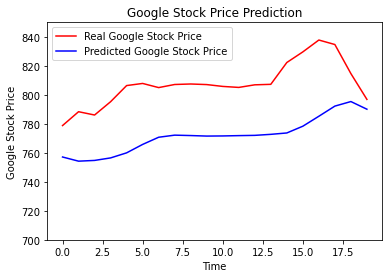

In [28]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.ylim(700,850)
plt.show()